# Geospatial Analysis & Visualization with Python

## Lets Get Started!

### The first step with any python project is to import our packages

* We'll be working with five packages today: Numpy, Pandas, Geopandas, Scipy, and Matplotlib
    * Numpy is a package for dealing with multidmensionsal dataset
    * Pandas is general use package for working with tabular dataset
    * Geopandas is a geospatial exentson for Pandas
        * It to allow us to work with vector data (points, lines, & polgons)
    * Scipy is a statical pagckage
        * It will alow us to do linear regression and calculate chisquare
    * Matplotlib is a powerful plotting library that can be used to make visualizations

In [287]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt
%matplotlib notebook

# Now we can load the data

# Lets start with the records of police killings

* We'll load the Police Killing Data as a "DataFrame" using pandas
    * Then we'll convert it into a "GeoDataFrame" using Geopandas
        * To do this, we must assign the "geometry".  In this case its point data, and the coordinates are in lat/long
        * Then we need to assign a Coordiante Reference System (CRS) manually
            * ESPG is a standardized code that is used to represent CRSs.
            * 'espg:4326' is for the refers to the WGS 1984 datum, which our latitude/longitude data is based in.
                * This is a CRS that is widely used by many web-based platforms because like Google Maps and Mapbox
                * The original only had addresses, not coordinates, so we used a webservice (Mapbox) to generate the coordinates of our addresses
* Once we have the data loaded, calling .head() will give us a "preview" of our dataset

In [424]:
# We import the Police Killings file, and set the incident ID as the index
police_Killings_Tabular = pd.read_csv('Data/PoliceKillings.csv',parse_dates=['date'],index_col=['id_incident'])

# We can then convert the pandas dataframe into a geopandas "GeodataFrame"
police_Killings = gpd.GeoDataFrame(police_Killings_Tabular,
    geometry=gpd.points_from_xy(police_Killings_Tabular.longitude, police_Killings_Tabular.latitude)
)

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
police_Killings.crs = WGS_1984

# Lets take a quick look.
police_Killings.head()

,date,date.1,day_week,prov,city_town,postal_code,location_type,id_victim,Name,age,...,taser_deployed,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,summary,latitude,longitude,geocoding_Notes,geometry
id_incident,,,,,,,,,,,,,,,,,,,,,
1,2012-01-06,2012-01-06,Fri,QC,Montreal,H3B 4W5,Urban,0001-V1,*****,34.0,...,No,Yes,No,Yes,Yes,Farshad Mohammadi was carrying a knife when he...,45.498173,-73.567157,NaN,POINT (-73.56716 45.49817)
2,2012-01-11,2012-01-11,Wed,AB,Onoway,T0E 1V0,Rural,0002-V1,*****,49.0,...,No,No,No,Unknown,Yes,RCMP called to an apartment complex in respons...,53.688760,-114.199440,NaN,POINT (-114.19944 53.68876)
3,2012-01-12,2012-01-12,Thu,ON,Oakville,L6H 0G6,Urban,0003-V1,*****,43.0,...,No,No,No,Unknown,Unknown,Kyle Newman intentionally and repeatedly struc...,43.477098,-79.702193,NaN,POINT (-79.70219 43.47710)
4,2012-02-03,2012-02-03,Fri,ON,Toronto,M4C 1X5,Urban,0004-V1,*****,29.0,...,No,No,No,Yes,No,"Michael Eligon, who had been involuntarily com...",43.687560,-79.321000,NaN,POINT (-79.32100 43.68756)
5,2012-02-13,2012-02-13,Mon,ON,Hamilton,L8K 5J4,Urban,0005-V1,*****,27.0,...,No,No,No,Yes,Unknown,"Police had a stolen van under surveillance, an...",43.219570,-79.794930,NaN,POINT (-79.79493 43.21957)


# Now we'll load some data from the 2016 Census

* We have a tabular dataset of population data.  We'll load that using pandas

In [427]:
# We'll import the tabualr census data with pandas
Census_Tabular = pd.read_csv('Data/Census.csv',index_col=['PRUID'])
Census_Tabular.head()

* We also have a provincial boundary shapefile that we can load with geopandas.
    * Shapefile are used to store georphric data.  They already have projections and coordiantes associated with them.
    * Geopandas has similar functionality to pandas.  But the read_file() method had less options, so we have to set the index manually.

In [429]:
# We'll import provincial boundaries using geopandas
Provincial_Boundaries = gpd.read_file('Data/lpr_000b16a_e.shp').set_index('PRUID')
Provincial_Boundaries.head()

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry
PRUID,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083..."
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358..."
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710..."
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762..."
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005..."


# We want to join the tabular census data to the provincial boundary file.

* This will let us map the disparity by province and do a more detailed analysis

* PRUID is a "unique identifier" that represents the provinces.

    * Since both have the PRUID set as the index, we don't need to specify a join key.

In [430]:
Test_Join = Provinces.join(Census)
Test_Join.head()

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry,prov,...,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian
PRUID,,,,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# But our join fails :(

* ## Notice the NaN values

* Wonder Why?
    * Lets look at the index for both files?  Maybe we have a datatype missmatch?

In [432]:
print(Provincial_Boundaries.index.dtype)
print(Census_Tabular.index.dtype)

object
int64


## Sure enough!  The Provincial_Boundaries index is an "object", not an integer.

* We can fix that easily and then do the join!
    * We just need to change the datatype of the Provincial_Boundaries layer.

* ## How could we do this?
    * Hint The anser is in the cell above!!

In [436]:
dtype = 
Provincial_Boundaries.index = Provincial_Boundaries.index.astype(dtype)
Provincial_Boundaries = Provincial_Boundaries.join(Census)
Provincial_Boundaries.head()

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry,prov,...,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian
PRUID,,,,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NL,...,635,1375,335,220,75,60,145,255,45725,462186
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",PE,...,255,585,145,215,210,110,50,85,2735,133527
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",NS,...,1685,8115,1195,1540,1540,695,635,1390,51490,813453
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",NB,...,1285,2960,1230,735,1685,230,300,680,29380,693186
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",QC,...,133920,213740,62825,32405,8055,4575,9840,23040,182890,6949091


# Before we dig into the data, lets make a quick map.

## Our Layers need to be in the same coordinate system to match up properly on a map!

* We can re-project the police_Killings layer using the .to_crs function to set the CRS to that of the Provinces
    * The provinces layer uses the Canada Lambert Conformal Conic projection (LCC).  This is the standard projection used by stats canada and is ideally suited for displaying the whole of country.
        
### Once both datasets are in the same coordinate system, we can make a map!
* First we must define a plot, using the matplotlib.pyplot package.  We imported this earlier as "plt"
    * We use the plt.subplots() to create a figure, and we can define how big we want it to be
* Geoapndas can then use the .plot() fucntion to create a map using matplotlib.
    * We simply tell it what axis to draw the plot on with ax="axes"
    * Then set a few other parameters:
        * We just want the provinces as a grey background so we can set the color
        * We want to classify killings by race, so we can set race as the column.  THen we can add a legend to aid interpretation of the data

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


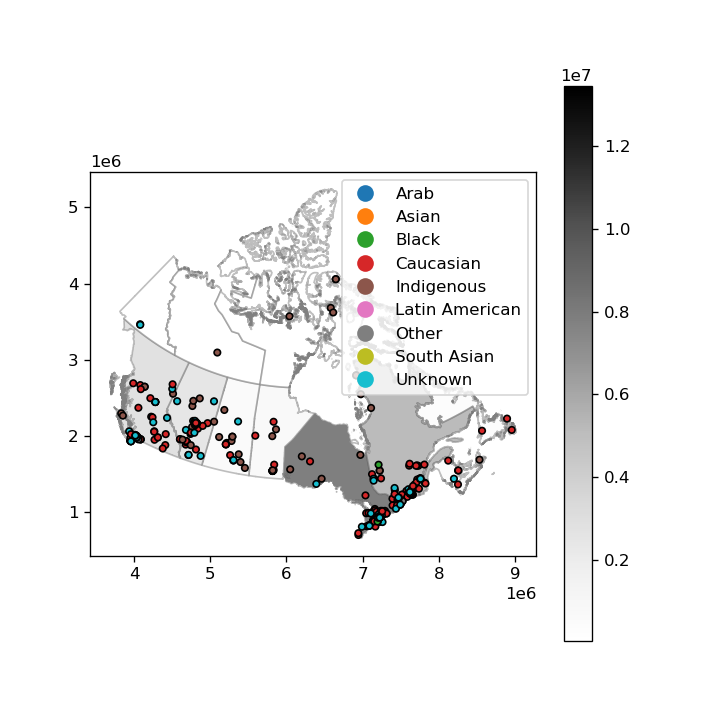

In [450]:
# We can use .to_crs() to create a police killings layer with the same projection as the provinces layer.
police_Killings = police_Killings.to_crs(Provinces.crs)

# Now, we can create a figure using matplotlib (plt), first we define the figure and the size
fig,axes=plt.subplots(
    figsize=(6,6)
)

# Now we can add the provinces using the .plot() function.  We set the plotting axes and give it a grey color
cb = Provincial_Boundaries.plot(
    ax=axes,
    alpha=.5,
    column='Total',
    cmap = 'Greys',
    edgecolor='grey',
    legend=True
)

# Then we add the police_Killings_LCC.  We'll set the column to 'race', so we can disply by race,
# give the point markers a few more parameters, and add them to a legend
police_Killings.plot(
    ax=axes,
    column='race',
    edgecolor='k',
    markersize=15,
    legend=True,
    legend_kwds={'loc': 'upper right','fontsize':10}
)
# lgnd = axes.legend()
# print(lgnd)
# lgnd.legendHandles[0]._legmarker.set_markersize(6)
# lgnd.legendHandles[1]._legmarker.set_markersize(6)

## And now you've made your first map with python!

* But notice, it doesn't look great.  This is just the quick and dirty way to look ata data

* To make things more presentable, we'll have to be more explicity in our definitions.  But that's a task for later.

* For now, lets move on and look at the dataset in more detail.

# Lets explore this dataset a bit further

## This dataset has information on many aspects of the incident.  The aspects we'll investigate today include: age, gender race, armed_type, mentral_distress_disorder.
* Pandas & Geopandas have some nice features to quickly summarize our dataset.
* We can use .count() to get the total # incidents.
    * Callling .count() as is, will give us a list of all the columns, and a count for each.  We can see most collumns are "full" but in the "geocoding_Notes" column, we can see that 4 points don't have coordinates associated with their address.  This suggests there was an error in the data entry process.  We don't need to worry about this though.    

In [290]:
police_Killings.count()

date                             462
id_incident                      462
date.1                           462
day_week                         462
prov                             462
city_town                        462
postal_code                      462
location_type                    462
id_victim                        462
Name                             462
age                              455
gender                           462
race                             462
ethnic_ancestry                  107
immigrant_refugee_naturalized    462
armed_type                       462
cause_death                      462
taser_deployed                   462
injured_officer                  462
excited_delirium                 462
mentral_distress_disorder        462
substance_abuse                  462
summary                          462
latitude                         458
longitude                        458
geocoding_Notes                    4
geometry                         462
d

* We can use .mean(), .min(), etc. followed by ['age'] to get some vital statistics on the age of victims.

In [291]:
print('Age Distribution of Victims')
print()
print('Mean:                ',
      police_Killings.mean()['age']
     )
print()
print('Standard Deviation:  ',
      police_Killings.std()['age']
     )
print()
print('Youngest:            ',
      police_Killings.max()['age']
     )
print()
print('Oldest:              ',
      police_Killings.min()['age']
     )

Age Distribution of Victims

Mean:                 36.73186813186813

Standard Deviation:   11.775739256991544

Youngest:             77.0

Oldest:               15.0


# Lets say we want to ask a more detailed question.  What's the distribution of police killings by race?

* We can use .groupby() to aggregate data by one or more categories.  After the groupby, we dictate "How" to aggregate.  Whether we want a count, a mean, etc.

* The sort_values() function is handy because it makes lists easier to interpret.

In [292]:
Race_Breakdown = police_Killings.groupby(['race']).count()['date'].sort_values()

Race_Breakdown

race
Latin American      3
Arab                5
Other               5
South Asian        10
Asian              15
Black              43
Indigenous         70
Unknown            99
Caucasian         212
Name: date, dtype: int64

# The racial demographics of Canada aren't evenly split however!


* ## So this information is missleading as its.


* ## We need to Normalize our data by population statistics.

* Lets import Provincial level Canadian Census Data.
* We'll set the index to the 'PRUID' column.  This is a unique provincial identifier used by stas Canada

,prov,Total,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian
PRUID,,,,,,,,,,,,,,,,
1,CA,35151728,1924635,1577060,1198545,780125,447320,523235,313260,264305,188710,92920,132090,232375,1673780,25803368
10,NL,519716,2645,2325,2350,1385,635,1375,335,220,75,60,145,255,45725,462186
11,PE,142907,925,2570,825,670,255,585,145,215,210,110,50,85,2735,133527
12,NS,923598,7905,8645,21910,3400,1685,8115,1195,1540,1540,695,635,1390,51490,813453
13,NB,747101,2535,3925,6995,1975,1285,2960,1230,735,1685,230,300,680,29380,693186


## Stats Canada's racial data categories don't perfectly match our police violence data

* But we do have white, indigenous, and black, which are the three largest groups in the police killing dataset.  So we'll focus on these groups.

* Exploring the other races on your own time could be a good way to get some practice.

* The first row (PRUID = 1) is the are the numbers for the whole country.
    * Lets use that info to calculate the national police killing rate
    
# We can query the datasets using the .loc[] function

## This query uses the .index, we can also search by column names.  Any one have a guess how we could reformat thie query to seach for prov == 'CA" instead?

In [294]:
Can_Pop = Census.loc[Census.index==1,['Total','Caucasian','Black','Indigenous']]

print(Can_Pop)

          Total  Caucasian    Black  Indigenous
PRUID                                          
1      35151728   25803368  1198545     1673780


# From here, we can calculate the police killing rate.

* Dividing the total number of killings by the population gives us ...

In [295]:
Race_Breakdown.sum() / Can_Pop['Total']

PRUID
1    0.000013
Name: Total, dtype: float64

# This number isn't that meaningful though.  It represents the number of killings "per person" over the whole study period.

## Lets convert the rate to a more meaninful unit.  Killings / Million Residents / Year

### The date record is a "date" object.
* It has some added functionality like being able to query the the year, month, day

### How might we use this info to calculate our police killing rate?

In [296]:
First_Year = police_Killings['date'].min().year
Last_Year = police_Killings['date'].max().year

Scale = 1e6
Duration = Last_Year-First_Year
rate_Conversion = Scale /  Duration
Rate = Race_Breakdown.sum() / Can_Pop['Total'] * rate_Conversion
print(Rate)

PRUID
1    0.773119
Name: Total, dtype: float64


# How does the rate vary by race?

In [297]:
Races = ['Caucasian','Black','Indigenous']
Rates = Race_Breakdown[Races]/Can_Pop[Races]*rate_Conversion
Rates


# Rates['BI'] = 
Race_Breakdown[['Black','Indigenous']].sum()/Can_Pop[['Black','Indigenous']].sum(axis=1)*rate_Conversion
# print(Rates[['Black','Indigenous']].mean(axis=1))
# print(Rates['BI'])

PRUID
1    2.314174
dtype: float64

# The Police killing rates are 5x higher for Indigenous people and 4x higher for Black people than white people.

# This is an abhorent example of systemic racism in Canadian Policing.

* We can make a graph to visually highlight this sever racial disparity.

In [298]:
fig, ax = plt.subplots(figsize = (6,6))
ax.barh(Races,Rates.values[0])
ax.set_title('Police Killings by Race in Canada')
ax.set_xlabel('Killings/Million Residents/Year')
plt.tight_layout()

<IPython.core.display.Javascript object>

## Now we  want to normalize the number of killings by population to get a rate

* We have a few more steps to go through first.
    * The police killings and census data use different abbreviations.  To do a join our dataset with the census data we'll need to assign an new abbreviaton
    * We'll us a dictionary to do this
* Then we can summarize the killings by province and join it to the Provinces_Join layer

## Now we can summarize the killings by province and join it to the Provinces_Join layer
* Note Prince Edward Island doesn't have any.

In [302]:

race_by_Province = police_Killings.groupby(['prov','race']).count()
# print(race_by_Province)
race_by_Province = race_by_Province['date'].unstack()#reset_index(level=0)
race_by_Province['Total'] = race_by_Province.sum(axis=1)
# 


race_by_Province = race_by_Province.fillna(0)


for col in ['Total','Caucasian','Black','Indigenous','Unknown']:
    Provinces_Join = Provinces_Join.join(race_by_Province[col],on='prov',rsuffix='_Killings')
#     Provinces_Join[col+'_Rate']=Provinces_Join[col+'_Killings']/Provinces_Join[col]*rate_Conversion
Provinces_Join

,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,AREA_LCC,AREA_AEA,Area_Merc,geometry,prov,...,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian,Total_Killings,Caucasian_Killings,Black_Killings,Indigenous_Killings,Unknown
PRUID,,,,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,Newfoundland and Labrador,Terre-Neuve-et-Labrador,N.L.,T.-N.-L.,397598.0,406998.00,1124050.0,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NL,...,60,145,255,45725,462186,3.0,3.0,0.0,0.0,0.0
11,Prince Edward Island,Prince Edward Island,Île-du-Prince-Édouard,P.E.I.,Î.-P.-É.,6023.0,5893.29,12384.0,"MULTIPOLYGON (((8435711.754 1679935.966, 84358...",PE,...,110,50,85,2735,133527,NaN,NaN,NaN,NaN,NaN
12,Nova Scotia,Nova Scotia,Nouvelle-Écosse,N.S.,N.-É.,57534.5,55643.30,111891.0,"MULTIPOLYGON (((8470851.646 1624745.011, 84710...",NS,...,695,635,1390,51490,813453,3.0,2.0,0.0,1.0,0.0
13,New Brunswic,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,74525.4,73050.60,154848.0,"MULTIPOLYGON (((8176224.537 1722553.460, 81762...",NB,...,230,300,680,29380,693186,4.0,3.0,0.0,0.0,1.0
24,Quebec,Quebec,Québec,Que.,Qc,1476350.0,1509750.00,4309780.0,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",QC,...,4575,9840,23040,182890,6949091,87.0,53.0,8.0,8.0,15.0
35,Ontario,Ontario,Ontario,Ont.,Ont.,980244.0,986723.00,2448600.0,"MULTIPOLYGON (((6378815.614 2295412.440, 63787...",ON,...,30835,97970,128590,374395,9188499,152.0,65.0,30.0,7.0,33.0
46,Manitoba,Manitoba,Manitoba,Man.,Man.,627595.0,649630.00,1979250.0,"MULTIPOLYGON (((6039656.509 2636304.343, 60396...",MB,...,1850,3200,6480,223310,838205,19.0,6.0,1.0,11.0,0.0
47,Saskatchewan,Saskatchewan,Saskatchewan,Sask.,Sask.,632214.0,652385.00,1940680.0,"POLYGON ((5248633.914 2767057.263, 5249285.640...",SK,...,955,1145,2815,175020,807467,17.0,4.0,0.0,11.0,2.0
48,Alberta,Alberta,Alberta,Alta.,Alb.,639937.0,663251.00,2044880.0,"POLYGON ((5228304.177 2767597.891, 5228098.463...",AB,...,12165,9905,28355,258640,2875365,71.0,29.0,2.0,11.0,22.0


In [305]:
# Provinces_Join['Police_Discrimination_Index'] = \
Provinces_Join['Black_Indigenous_Rate']=(Provinces_Join['Indigenous_Killings']+Provinces_Join['Black_Killings'])/\
(Provinces_Join['Indigenous']+Provinces_Join['Black'])*rate_Conversion

Provinces_Join['White_Rate']=Provinces_Join['Caucasian_Killings']/Provinces_Join['Caucasian']*rate_Conversion

Provinces_Join['Police_Discrimination_Index'] = Provinces_Join['Black_Indigenous_Rate'] - Provinces_Join['White_Rate']

Provinces_Join['Police_Discrimination_Index']=Provinces_Join['Police_Discrimination_Index'].fillna(0)

print(Provinces_Join[['prov','Police_Discrimination_Index']].sort_values(by='Police_Discrimination_Index'))


bins = [-0.483293,0.483293,0.773119,2.314174,10]
labels = ['No Biaias','Slight Bias','Severe Bias','Extreme Bias']
Provinces_Join['PDI']=(pd.cut(Provinces_Join['Police_Discrimination_Index'],bins=bins,labels=labels))

      prov  Police_Discrimination_Index
PRUID                                  
10      NL                    -0.381817
13      NB                    -0.254579
11      PE                     0.000000
12      NS                     0.656784
48      AB                     1.377439
24      QC                     1.425764
35      ON                     1.755767
59      BC                     2.073789
46      MB                     2.361831
61      NT                     2.720792
47      SK                     3.115161
60      YT                     6.949029
62      NU                     9.524535


### We can fix this easily using the .fillna() function

### The we can do the normalization!!

* We'll calculat the rate of police killings per ... ten thousand?
    * Divide the number of killings, by the total population.  To get the per person rate
    * Then multiply by 1 million
    * Then sort the values
    
* Then we'll plot it on a map, with a bar graph below for extra context!

In [317]:
# fig,ax = plt.subplots(figsize = (8,8))

# Okay, now we're ready to normalize

In [397]:
Temp = police_Killings.copy()

for r in Temp['armed_type'].unique():
    replace = {'Air gun, replica gun':'Firearm',
              'Bat, club, other swinging object':'Other weapons',
            'Vehicle':'Other weapons',
              'Knife, axe, other cutting instruments':'Knife',
              'Unknown':'None'
              }
    if r in replace.keys():
        Temp.loc[Temp['armed_type']==r,'armed_type']=replace[r]
        

Armed = Temp.groupby(['race','armed_type']).count()['date'].unstack().fillna(0)#/\
# (Armed.T/Armed.sum(axis=1))[['Caucasian','Black','Indigenous']]
Observed = Armed.T[['Caucasian','Black','Indigenous']]

Expected = Observed.copy()

Expected = Armed.T.sum(axis=1).values[:,np.newaxis]*\
       Can_Pop[['Caucasian','Black','Indigenous']].values/Can_Pop['Total'].values

# police_Killings.groupby('race').count()['date'].values

In [398]:
# police_Killings.groupby('immigrant_refugee_naturalized').count()
print(Expected)

print(Observed)

print(scipy.stats.chisquare(Observed,Expected))

Yearly=police_Killings.set_index('date').resample('Y').count()
# print(Yearly)

reg=scipy.stats.linregress(Yearly.index.year,Yearly.race)
# plt.figure()
ax2.bar(Yearly.index.year,Yearly.race,edgecolor='k')
print(reg)
ax2.plot(Yearly.index.year,Yearly.index.year*reg.slope+reg.intercept,color='k',
         label = 'Slope = '+str(np.round(reg.slope,2))+' Killings per Year '\
        ' P = '+str(np.round(reg.pvalue,2)))
ax2.legend()

[[ 84.41654191   3.92107822   5.47582469]
 [112.31070359   5.21673885   7.28522763]
 [102.03390718   4.73939019   6.61860549]
 [ 40.37312874   1.87529828   2.61887268]]
race           Caucasian  Black  Indigenous
armed_type                                 
Firearm             55.0   10.0        19.0
Knife               68.0   16.0        31.0
None                64.0   12.0        16.0
Other weapons       25.0    5.0         4.0
Power_divergenceResult(statistic=array([ 47.76410091,  48.04336656, 124.62378673]), pvalue=array([2.39040172e-10, 2.08470799e-10, 7.78884256e-27]))
LinregressResult(slope=1.0485036119711042, intercept=-2080.252837977296, rvalue=0.7543604262227599, pvalue=0.0002978828736845745, stderr=0.22810752954681113)


<IPython.core.display.Javascript object>


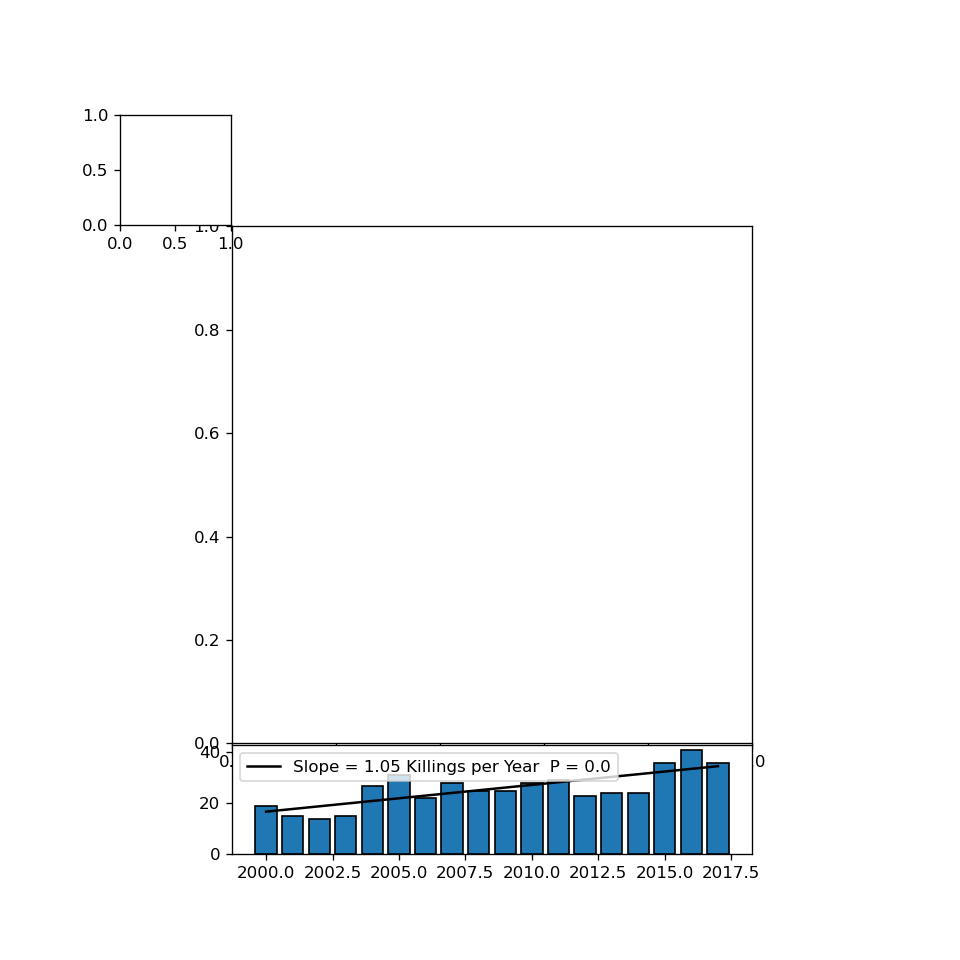

In [396]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(100,100)

ax = fig.add_subplot(gs[15:85, 15:85])


ax1 = fig.add_subplot(gs[0:15, 0:15])
ax2 = fig.add_subplot(gs[85:,15:85])
# ax3 = fig.add_subplot(gs[3:, :3]),
# ax4 = fig.add_subplot(gs[3:, 3:])


# Provinces_Killings['Indigenous_pct'] = Provinces_Killings['Indigenous']/Provinces_Killings['Total']
# Provinces_Killings['Black_pct'] = Provinces_Killings['Black']/Provinces_Killings['Total']

# Provinces_Killings.plot(ax=ax1,column='Rate',edgecolor='k',legend=True,scheme='natural_breaks')
# # ax3.bar(Provinces_Killings.index,Provinces_Killings['Rate'])
# # ax3.set_xticklabels(Provinces_Killings.index,rotation=30)
# Total = police_Killings.groupby('race').count()
# Rate = []
# Races = ['Black','Indigenous','Caucasian','Asian','South Asian']
# for race in Races:
#     Rate.append((Total['date'].T[race]/Provinces_Killings[race]).values[0]*1e6/17)
# Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
# ax4.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
# ax4.set_title('Police Killing Rates in Canada')
# ax4.set_ylabel('Killings/Year/Million Residents')
# for breaks

# Provinces_Join.plot(ax=ax3,column='PDI',edgecolor='k',legend=True)#,scheme='natural_breaks')
# Provinces_Killings.plot(ax=ax2,column='Black_pct',edgecolor='k',legend=True,scheme='natural_breaks')
# plt.suptitle('Police Killing Rates Across Canada')

### Nunavut obviously has a serious problem.  75% of its population is Inuit & its rate is an order of magnitude higher than the other provinces or teritories.

### BC is the worst to of the provinces.  Lets select BC and investigate further.

* For We can select BC using the PREABBR value.
* We'll also re-project into UTM Zone 10 N, this is a more accurate coordinate system for this region

* Then we can look at the racial breakdown of killings in BC using the .groupby function again.
    * We'll create a new dataframe normalizing total killings for different races by total population within those groups
    * Then we can make a barplot highlighting racial biases 


In [327]:
Mental_Health = police_Killings.groupby('mentral_distress_disorder').count()
ax1.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})

([<matplotlib.patches.Wedge at 0x221b7486448>,
 [Text(1.0689927233164507, 0.2593348366426671, 'No'),
  Text(-0.5238883537010176, 0.9672336805841893, 'Unknown'),
  Text(0.28108682195513623, -1.0634802294933186, 'Yes')],
 [Text(0.5830869399907912, 0.14145536544145476, '7.6%'),
  Text(-0.2857572838369186, 0.527582007591376, '50.6%'),
  Text(0.15332008470280156, -0.5800801251781738, '41.8%')])

In [326]:
# ax3.set_title('PD Descrim Rayte')


Provinces_Join.plot(ax=ax,column='PDI',edgecolor='k',legend=True)

# ax2.plot([1,2],[0,1])
# plt.tight_layout()

In [314]:
# 26910
BC = Provinces_Killings.loc[Provinces_Killings.index=='B.C.'].to_crs(26910)
BC_Killings = police_Killings.loc[police_Killings['PREABBR']=='B.C.'].to_crs(26910)
Total_BC = BC_Killings.groupby('race').count()

Rate = []
Races = ['Black','Indigenous','Caucasian','Asian','South Asian']
for race in Races:
    Rate.append((Total_BC['date'].T[race]/BC[race]).values[0]*1e6/17)
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
plt.figure()
plt.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
plt.title('Police Killing Rates in BC')
plt.ylabel('Killings/Year/Million Residents')
plt.savefig('BCPoliceKillings.png')
# print(Total_BC['Black']/BC['Black'])

# fig,ax=plt.subplots(figsize=(6,6))

# BC.plot(ax=ax,color='grey',edgecolor='k')
# BC_Killings.plot(ax=ax,column='race',legend=True)
# print(Canada.head())

# from fiona.crs import from_epsg
# from_epsg(2193)
# # Proj({'init': 'epsg:2193', 'no_defs': True}, preserve_flags=True)

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


KeyError: 'PREABBR'

## Lets make an infographic for BC, summarizing some of the key points

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(10,10)
ax0 = fig.add_subplot(gs[0:6, 0:6])
BC.plot(ax=ax0,color='grey',edgecolor='k')
BC_Killings.plot(ax=ax0,column='race',legend=True,edgecolor='k')
ax0.axes.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(False)
ax0.set_title('Police Killings in BC 2000-2017')


ax1 = fig.add_subplot(gs[1:5, 6:])

Mental_Health = BC_Killings.groupby('mentral_distress_disorder').count()
ax1.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax1.set_title('Was it a Mental Health Crisis?')
# ax1.bar(BC_Year.index,BC_Year.race,width=300,edgecolor='k')
# ax1.set_title('Police Killings by Year in BC')
# ax1.set_ylabel('Number')

ax2 = fig.add_subplot(gs[6:, 0:6])
ax2.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
ax2.set_title('Police Killing Rates by Race in BC')
ax2.set_ylabel('Killings/Year/Million Residents')
ax2.set_xticklabels(Normalized_Rates.index,rotation=30)

BC_Killings.loc[BC_Killings.armed_type=='Knife, axe, other cutting instruments','armed_type']='Knife/Axe'
BC_Killings.loc[BC_Killings.armed_type=='Bat, club, other swinging object','armed_type']='Bat/Club'
BC_Killings.loc[BC_Killings.armed_type=='Air gun, replica gun','armed_type']='Fake Gun'
BC_Killings.loc[BC_Killings.armed_type=='Unknown','armed_type']='None'
Mental_Health = BC_Killings.groupby('armed_type').count()
ax3 = fig.add_subplot(gs[6:, 6:])
ax3.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax3.set_title('Were They Armed?')


plt.tight_layout()
# ax0 = fig.add_subplot(gs[0:6, 0:6])